#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite difference methods for transient PDE

## Method of Lines

Our method for solving time-dependent problems will be to discretize in space first, resulting in a system of ordinary differential equations

$$ M \dot u = f(u) $$

where the "mass matrix" $M$ might be diagonal and $f(u)$ represents a spatial discretization that has the form $f(u) = A x$ for linear problems.

### Second Order Equations

A second order system such as

$$ \ddot u = f(t, u, \dot u) $$

may always be converted to a first order system by introducing a new variable

$$ \begin{bmatrix} u_0 \\ u_1 \end{bmatrix}' = \begin{bmatrix} u_1 \\ f(t, u_0, u_1) \end{bmatrix} . $$
Therefore, without loss of generality, we will focus on first order systems.

### Implicit formulations

We have chosen the representation $M \dot u = f(t,u)$, but it is more general to write $h(t,u,\dot u) = 0$.
If $\partial h/\partial \dot u$ is singular, then this describes a *differential algebraic equation* (DAE).  General DAE are more challenging to solve and beyond the scope of this course, though we will allow a special case.  We will consider cases in which the mass matrix $M$ is singular due to zero rows -- this is sometimes convenient to enforce boundary conditions and results in an "index 1" DAE.

## Linear Equations

If $f(u) = A u$ is a linear function of $u$ then we have a linear ODE
$$ \dot u = A(t) u + \text{source}(t) . $$
If $A(t)$ is independent of $t$ and $\text{source}(t) = 0$ then we have a linear, constant, autonomous ODE.

#### Non-autonomous ODE

Our ODE is "non-autonomous" if $\text{source}(t) \ne 0$.  In that case, we can augment our system with a new independent variable $u_s$ and equation $u_s = 1$, then substitute $t = u_s$ to arrive at an equivalent autonomous formulation.  The augmented equation will be integrated exactly using every method that we will consider.  So there is no loss of generality by assuming that the system is autonomous, though many production ODE solvers will have direct support for non-autonomous systems.

### Exponentials

When $u$ is a scalar then $A = \lambda$ is a scalar and the solution is
$$ u(t) = u(0) e^{\lambda t} . $$

#### Question
What qualitative dynamics does this imply for
* $a > 0$?
* $a < 0$?
* $a$ imaginary?

#### Question
* What if $A$ is diagonal?
* What if $A = X \Lambda X^{-1}$?

#### Matrix exponential
The general solution can be written in terms of the matrix exponential.
$$ u(t) = e^{At} u(0) . $$
The matrix exponential is defined by its Taylor series
$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are [many practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

### Forward Euler Method

The simplest method for solving $\dot u(t) = f(t,u)$ is
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$

Let's try this on a scalar problem

$$ \dot u = -k (u - \cos t) $$

where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

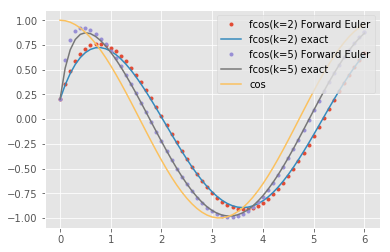

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def ode_euler(f, u0, tfinal=1, h=0.1):
    u = numpy.array(u0)
    t = 0
    thist = [t]
    uhist = [u0]
    while t < tfinal:
        h = min(h, tfinal - t)
        u += h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

tests = []

class fcos:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'fcos(k={:d})'.format(self.k)
    def f(self, t, u):
        return -self.k * (u - numpy.cos(t))
    def u(self, t, u0):
        k2p1 = self.k**2+1
        return (u0 - self.k**2/k2p1) * numpy.exp(-self.k*t) + self.k*(numpy.sin(t) + self.k*numpy.cos(t))/k2p1

tests.append(fcos(k=2))
tests.append(fcos(k=5))

u0 = numpy.array([.2])
pyplot.figure()
for test in tests:
    thist, uhist = ode_euler(test.f, u0, h=.1, tfinal=6)
    pyplot.plot(thist, uhist, '.', label=repr(test)+' Forward Euler')
    pyplot.plot(thist, test.u(thist, u0), label=repr(test)+' exact')
pyplot.plot(thist, numpy.cos(thist), label='cos')
pyplot.legend(loc='upper right');

#### Questions
* What happens when $h$ is increased?
* What if $k$ is increased?

#### Example: Linear system

Now we consider linear systems

$$ \dot u = A u $$

which have an exact solution $u(t) = e^{At} u(0)$ in terms of the matrix exponential.

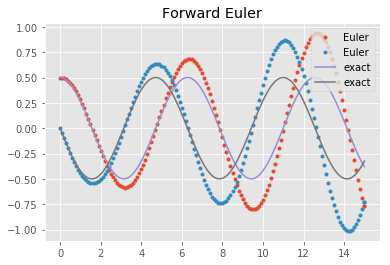

In [2]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A.dot(u)
    def u(self, t, u0):
        return [numpy.real(expm(self.A*s).dot(u0)) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))
u0 = numpy.array([.5, 0])
thist, uhist = ode_euler(test.f, u0, h=.1, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.u(thist, u0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Forward Euler');

#### Questions
* Does shrinking $h$ make this more accurate?
* What if `tfinal` is extended?
* What are the eigenvalues of $A$?

### Implicit methods
Recall that forward Euler is the step
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde u(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde u(h) = u(0) + h f(h, \tilde u(h)) . $$
This is a (generally) nonlinear equation for $\tilde u(h)$.

We'll discuss the nonlinear case later and consider the linear case $f(t,u) = A u$, for which backward Euler reduces to

$$ \tilde u(h) = u(0) + h A \tilde u(h) $$

or

$$ (I - h A) u(h) = u(0) . $$
This requires solving a linear system involving both $h$ and $A$.  Depending on the problem, this may be significantly more expensive than merely multiplying by $A$.

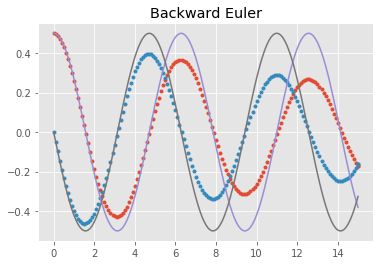

In [3]:
def ode_beuler_linear(A, u0, tfinal=1, h=0.1):
    u = numpy.array(u0)
    t = 0
    thist = [t]
    uhist = [u0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve (I - hA)u = u(0)
        u = numpy.linalg.solve(numpy.eye(len(u)) - h*A, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

thist, uhist = ode_beuler_linear(test.A, u0, h=.1, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.')
pyplot.plot(thist, test.u(thist, u0))
pyplot.title('Backward Euler');

### Midpoint Method

What if instead of evaluating the function at the end of the time step, we evaluated in the middle of the time step using the average of the endpoint values.

$$ \tilde u(h) = u(0) + h f\left(\frac h 2, \frac{\tilde u(h) + u(0)}{2} \right) $$

For the linear problem, this reduces to

$$ \Big(I - \frac h 2 A \Big) u(h) = \Big(I + \frac h 2 A\Big) u(0) .$$

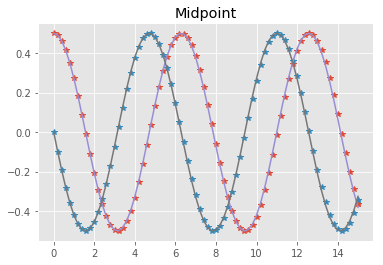

In [4]:
def ode_midpoint_linear(A, u0, tfinal=1, h=0.1):
    u = u0.copy()
    t = 0
    thist = [t]
    uhist = [u0]
    I = numpy.eye(len(u))
    while t < tfinal:
        h = min(h, tfinal - t)
        u = numpy.linalg.solve(I - .5*h*A, (I + .5*h*A).dot(u))
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

thist, uhist = ode_midpoint_linear(test.A, u0, h=.2, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '*')
pyplot.plot(thist, test.u(thist, u0))
pyplot.title('Midpoint');

### Linear Stability Analysis

Why did forward Euler diverge while backward Euler decayed and Midpoint is apparently quite accurate for long time periods?  We can answer this by considering the test equation
$$ \dot u = \lambda u $$
and applying each method to construct
$$ u(h) = R(h\lambda) u(0) $$
where $R(z)$ is called the **stability function**.

$$\begin{align} R(z) &= 1+z & \text{Forward Euler} \\
R(z) &= \frac{1}{1-z} & \text{Backward Euler} \\
R(z) &= \frac{1+z/2}{1-z/2} & \text{Midpoint}
\end{align}$$

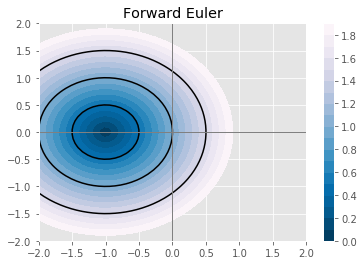

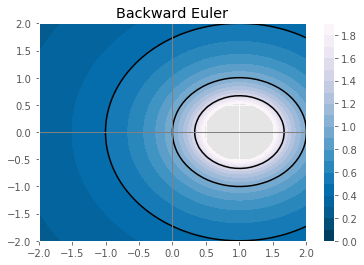

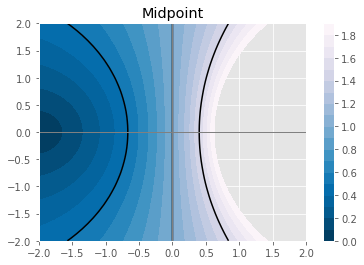

In [5]:
x = numpy.linspace(-2,2)
xx, yy = numpy.meshgrid(x, x)
zz = xx + 1j*yy
Rlist = [('Forward Euler', 1+zz),
        ('Backward Euler', 1/(1-zz)),
        ('Midpoint', (1+zz/2)/(1-zz/2))]
for Rlabel, R in Rlist:
    pyplot.figure()
    C = pyplot.contourf(xx, yy, numpy.abs(R), numpy.arange(0,2,.1), cmap=pyplot.cm.PuBu_r)
    pyplot.colorbar(C)
    pyplot.axvline(x=0, linewidth=1, color='grey')
    pyplot.axhline(y=0, linewidth=1, color='grey')
    pyplot.contour(xx, yy, numpy.abs(R), numpy.arange(0,2,.5), colors='k')
    pyplot.title(Rlabel);